# Label Propagation Algorithm — Explanation

Label Propagation is a semi-supervised learning method that uses both labeled and unlabeled data.  
The central idea: **labels spread through a graph based on similarity**.

## Key Steps
1. **Build a graph** where each data point is a node.
2. **Compute similarities (affinity matrix)** between nodes:
   - Often done using an RBF kernel:  
     `W[i,j] = exp(-||xi - xj||² / (2σ²))`
3. **Normalize rows** to create a transition matrix `T`, which represents probabilities of moving from one node to another.
4. **Initialize label matrix F**:
   - Labeled nodes get one-hot labels.
   - Unlabeled nodes start at 0.
5. **Iterate update rule**:
F ← α T F + (1 - α) Y
- `α` controls how much to blend old predictions vs fixed labels.
- `Y` stores original known labels.
6. **Clamp labeled nodes** so their labels never change.
7. **Stop when converged.**

## Outcome
- Unlabeled nodes receive a soft class distribution.
- Final labels are chosen via `argmax` over the distribution.

This method works well when:
- Data has clear cluster structures.
- Only a small fraction of labels are available.


# Label Propagation From Scratch (Python Implementation)

This notebook implements a complete label propagation algorithm, generates a dataset, trains the model, and visualizes results.




In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

import sys
sys.path.append("/Users/rykerdolese/Documents/INDE 577/Data-Science-and-Machine-Learning/src")

from mlpackage import LabelPropagationCustom

# plotting defaults
%matplotlib inline
plt.rcParams.update({'figure.figsize': (7,5)})


import warnings
warnings.filterwarnings('ignore')

In [3]:
X, y_true = make_moons(n_samples=600, noise=0.12, random_state=42)

rng = np.random.default_rng(0)
y = np.full_like(y_true, -1)
for cls in [0,1]:
    idx = np.where(y_true == cls)[0]
    chosen = rng.choice(idx, size=3, replace=False)
    y[chosen] = cls

print("Labeled points per class:", np.bincount(y[y != -1]))


Labeled points per class: [3 3]


In [39]:
model = LabelPropagationCustom(alpha=0.9, sigma=0.4, max_iter=500)
model.fit(X, y)
y_pred = model.predict()


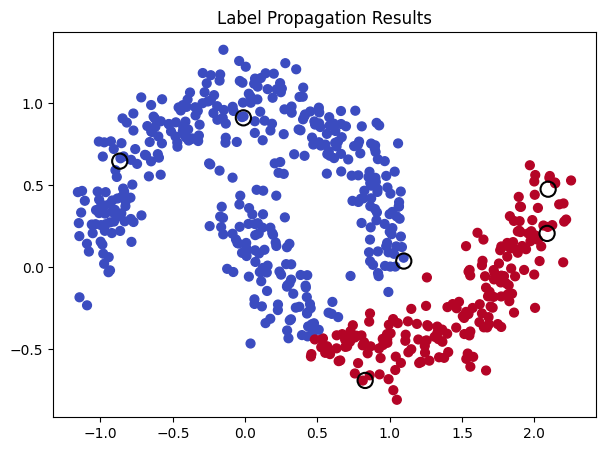

In [40]:
def plot_result(X, y_labeled, y_pred, title):
    fig, ax = plt.subplots(figsize=(7,5))
    unlabeled = (y_labeled == -1)

    ax.scatter(X[unlabeled,0], X[unlabeled,1], c=y_pred[unlabeled], s=40, cmap='coolwarm')
    ax.scatter(X[~unlabeled,0], X[~unlabeled,1], facecolors='none',
               edgecolors='k', s=120, linewidths=1.5, label='Labeled')

    ax.set_title(title)
    plt.show()

plot_result(X, y, y_pred, 'Label Propagation Results')

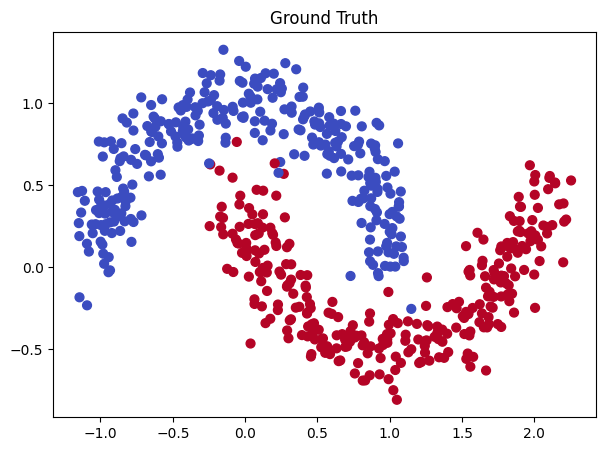

In [41]:
plt.scatter(X[:,0], X[:,1], c=y_true, cmap='coolwarm', s=40)
plt.title("Ground Truth")
plt.show()


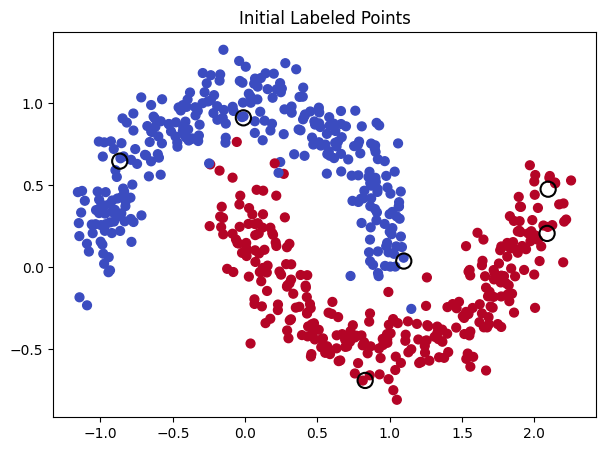

In [42]:
plot_result(X, y, y_true, "Initial Labeled Points")


Here, we are trying an experiment using different hyperparameter combinations to see if it separates the classes well.

Running Label Propagation: alpha=0.6, sigma=0.2


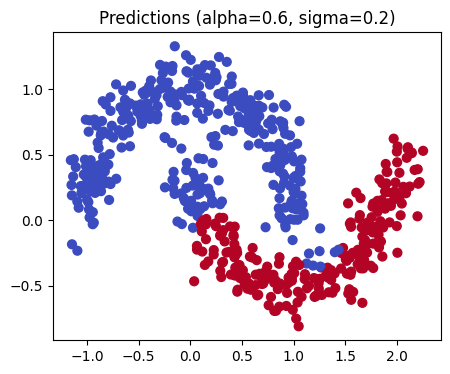

Accuracy: 0.902, F1: 0.891, Precision: 1.000, Recall: 0.803
Confusion Matrix:
 [[300   0]
 [ 59 241]]
--------------------------------------------------
Running Label Propagation: alpha=0.6, sigma=0.4


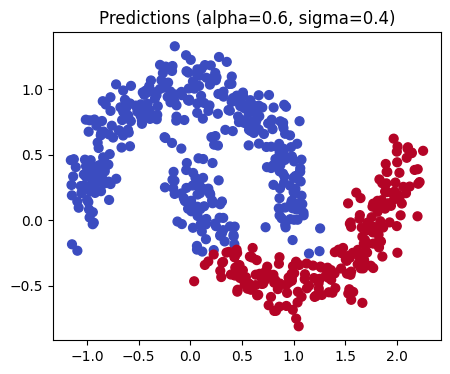

Accuracy: 0.867, F1: 0.846, Precision: 1.000, Recall: 0.733
Confusion Matrix:
 [[300   0]
 [ 80 220]]
--------------------------------------------------
Running Label Propagation: alpha=0.6, sigma=0.6


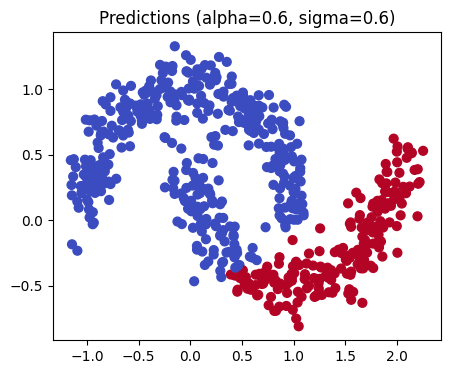

Accuracy: 0.835, F1: 0.803, Precision: 0.995, Recall: 0.673
Confusion Matrix:
 [[299   1]
 [ 98 202]]
--------------------------------------------------
Running Label Propagation: alpha=0.8, sigma=0.2


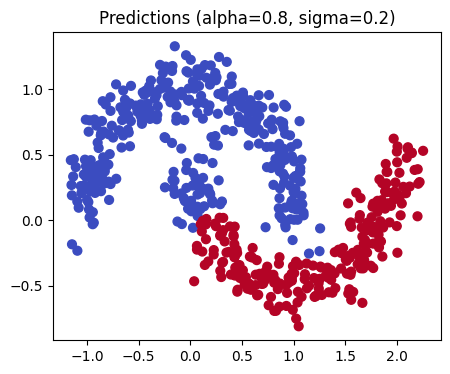

Accuracy: 0.910, F1: 0.901, Precision: 1.000, Recall: 0.820
Confusion Matrix:
 [[300   0]
 [ 54 246]]
--------------------------------------------------
Running Label Propagation: alpha=0.8, sigma=0.4


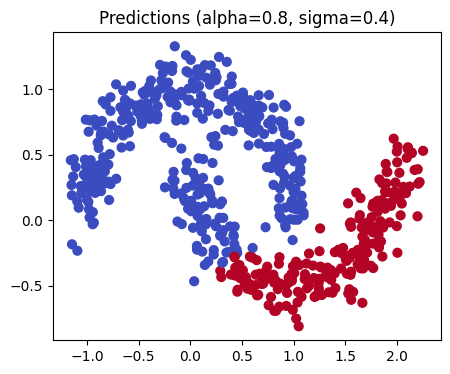

Accuracy: 0.850, F1: 0.824, Precision: 0.995, Recall: 0.703
Confusion Matrix:
 [[299   1]
 [ 89 211]]
--------------------------------------------------
Running Label Propagation: alpha=0.8, sigma=0.6


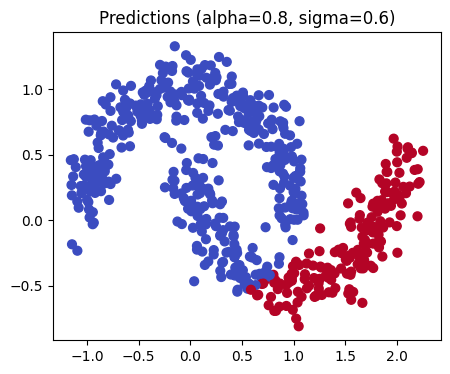

Accuracy: 0.792, F1: 0.738, Precision: 0.994, Recall: 0.587
Confusion Matrix:
 [[299   1]
 [124 176]]
--------------------------------------------------
Running Label Propagation: alpha=0.9, sigma=0.2


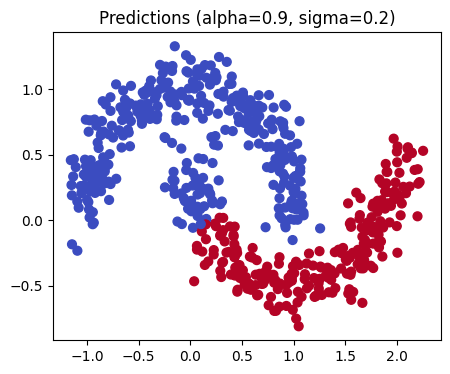

Accuracy: 0.902, F1: 0.891, Precision: 0.996, Recall: 0.807
Confusion Matrix:
 [[299   1]
 [ 58 242]]
--------------------------------------------------
Running Label Propagation: alpha=0.9, sigma=0.4


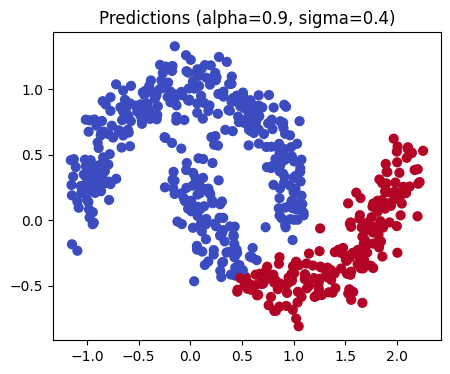

Accuracy: 0.825, F1: 0.789, Precision: 0.995, Recall: 0.653
Confusion Matrix:
 [[299   1]
 [104 196]]
--------------------------------------------------
Running Label Propagation: alpha=0.9, sigma=0.6


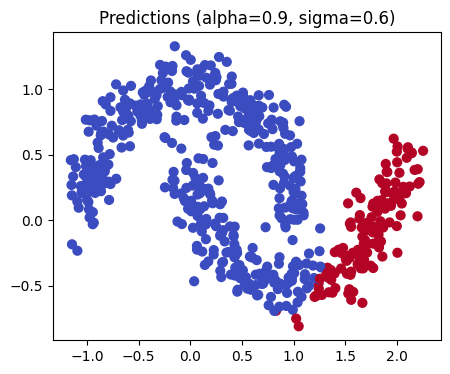

Accuracy: 0.718, F1: 0.608, Precision: 1.000, Recall: 0.437
Confusion Matrix:
 [[300   0]
 [169 131]]
--------------------------------------------------


In [44]:
alphas = [0.6, 0.8, 0.9]      # propagation factors
sigmas = [0.2, 0.4, 0.6]      # RBF bandwidths

results = []

# Loop over all combinations
for alpha in alphas:
    for sigma in sigmas:
        print(f"Running Label Propagation: alpha={alpha}, sigma={sigma}")
        
        # Fit model
        model = LabelPropagationCustom(alpha=alpha, sigma=sigma, max_iter=1000)
        model.fit(X, y)
        y_pred = model.predict()
        
        # Compute metrics
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        
        results.append({
            "alpha": alpha,
            "sigma": sigma,
            "accuracy": acc,
            "f1": f1,
            "precision": precision,
            "recall": recall,
            "confusion_matrix": cm
        })
        
        # Plot predicted labels
        plt.figure(figsize=(5,4))
        plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='coolwarm', s=40)
        plt.title(f"Predictions (alpha={alpha}, sigma={sigma})")
        plt.show()
        
        # Print metrics
        print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
        print("Confusion Matrix:\n", cm)
        print("-"*50)


It appears that higher alpha and lower sigma values perform best. However, as seen in the DBSCAN notebook, it appears that algorithm performs much better on a non-linear dataset like make moons. In that case DBSCAN should likely be chosen.